In [3]:
#Based on this https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [4]:
pip install -r cluster-requirements.txt  #might be some missing, let me know if so

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#might'


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import little_mallet_wrapper as lmw

import os

from pathlib import Path

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OMars\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [30]:
#Replace below with filepath to csv with text (as twitter.tweet/text)

file = r'C:\Users\OMars\Documents\CASM_offline\Citizens-Advice\post-clean-for-clustering.csv'
file = str(file)
#print(file)
#df = pd.read_csv(file)

#hard-coded row count as counting method takes ages

row_count = 4420068

#row_count = 0

#for row in open(file, "r",encoding='utf-8'):
    #row_count += 1

#print(row_count)
    
n = input('Sample every nth cell, where n = ')
n = int(n)

#create pandas dataframe from only every nth row from csv - taken from https://stackoverflow.com/questions/53812094/select-every-nth-row-as-a-pandas-dataframe-without-reading-the-entire-file

skip = np.arange(row_count)
skip = np.delete(skip, np.arange(0, row_count, n))
df = pd.read_csv(file, skiprows = skip)
df = df.replace(r'\r+|\n+|\t+','', regex=True)
df.index.name = 'id'
        
print('df created')
print(df.head())


Sample every nth cell, where n = 1000
df created
   classify/post-classifier-v3-29-03-18-issue  \
id                                              
0                                       issue   
1                                       issue   
2                                         NaN   
3                                         NaN   
4                                       issue   

   classify/post-classifier-v3-29-03-18-not-issue     twitter.tweet/created  \
id                                                                            
0                                             NaN  2017-01-22T13:24:15.000Z   
1                                             NaN  2017-01-23T13:05:29.000Z   
2                                       not-issue  2017-01-23T19:06:03.000Z   
3                                       not-issue  2017-01-24T16:03:32.000Z   
4                                             NaN  2017-01-25T11:44:10.000Z   

      twitter.tweet/id                               

In [32]:
#make text into processed list of words.  Look at gensim documentation for processing info.

data = list(df['twitter.tweet/text'])  
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['royalmail', 'why', 'did', 'you', 'get', 'rid', 'of', 'smaller', 'collection', 'depots', 'in', 'portsmouth', 'having', 'one', 'with', 'no', 'public', 'transport', 'access', 'is', 'the', 'worst']]


In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['royalmail', 'why', 'did', 'you', 'get', 'rid', 'of', 'smaller', 'collection', 'depots', 'in', 'portsmouth', 'having', 'one', 'with', 'no', 'public', 'transport', 'access', 'is', 'the', 'worst']


In [34]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [35]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

In [36]:
#nlp = spacy.load("en")
nlp = spacy.load("en_core_web_sm")

In [37]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

print(data_lemmatized[:1])

[['royalmail', 'rid', 'small', 'collection', 'depot', 'portsmouth', 'public', 'transport', 'access', 'worst']]


In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#filter out really commmon / uncommon words - see link in top cell for info. May not always be needed.

id2word.filter_extremes(no_below=5, no_above=0.5)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [54]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           #random_state=100,
                                           #update_every=1,
                                           #chunksize=100,
                                           #passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(5,
  '0.034*"speak" + 0.032*"service" + 0.026*"royalmail" + 0.021*"phone" + '
  '0.019*"useless" + 0.018*"bad" + 0.016*"customer" + 0.016*"thank" + '
  '0.015*"want" + 0.015*"try"'),
 (11,
  '0.033*"deliver" + 0.028*"receive" + 0.027*"royalmail" + 0.026*"item" + '
  '0.024*"delivery" + 0.024*"pay" + 0.021*"claim" + 0.016*"damage" + '
  '0.016*"week" + 0.014*"review"'),
 (23,
  '0.037*"hermesparcel" + 0.026*"royalmailhelp" + 0.025*"royalmail" + '
  '0.024*"delivery" + 0.021*"parcel" + 0.019*"day" + 0.018*"thank" + '
  '0.018*"time" + 0.018*"sit" + 0.018*"today"'),
 (3,
  '0.060*"hermesparcel" + 0.039*"delivery" + 0.033*"parcel" + 0.020*"people" + '
  '0.015*"time" + 0.014*"come" + 0.014*"email" + 0.012*"go" + 0.011*"get" + '
  '0.011*"call"'),
 (24,
  '0.031*"royalmailhelp" + 0.028*"leave" + 0.024*"hermesparcel" + '
  '0.024*"parcel" + 0.023*"item" + 0.019*"send" + 0.016*"number" + '
  '0.016*"yodelonline" + 0.015*"contact" + 0.014*"delivery"'),
 (20,
  '0.033*"hermesparcel" + 0.030*"

In [ ]:
# Compute Perplexity - a measure of how good the model is. lower the better.

#print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', coherence_lda)

In [56]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.030218  0.026606       1        1  6.238791
22    -0.080789  0.059300       2        1  6.101201
12     0.002028 -0.015959       3        1  5.260447
10    -0.025909  0.002900       4        1  5.117812
13    -0.042203 -0.030210       5        1  4.882679
4     -0.060850 -0.007641       6        1  4.598016
9     -0.003050  0.034338       7        1  4.546316
7     -0.030223 -0.001531       8        1  4.512343
21    -0.082477  0.068100       9        1  4.416841
6     -0.034776 -0.050897      10        1  4.219607
18     0.191728  0.098679      11        1  4.138876
19    -0.074844  0.014277      12        1  4.133218
14    -0.003649  0.080976      13        1  3.785786
0     -0.024312 -0.067491      14        1  3.780707
1      0.002298  0.091289      15        1  3.596494
15     0.076388 -0.140683      16        1  3.446085
20     0.018926  0.076843      17        1  3.343720
3     -0.036948  0.021818      18        1  3.184885
23     0.000880 -0.014964      19        1  3.088824
11    -0.067582 -0.003150      20        1  3.072153
16     0.019290 -0.021908      21        1  3.064686
2     -0.000355 -0.050691      22        1  3.022149
24    -0.030106 -0.127319      23        1  3.020756
17     0.094690 -0.034623      24        1  2.828335
5      0.222065 -0.008060      25        1  2.599274, topic_info=              Term        Freq       Total Category  logprob  loglift
137        service  359.000000  359.000000  Default  30.0000  30.0000
869  royalmailhelp  407.000000  407.000000  Default  29.0000  29.0000
57         deliver  663.000000  663.000000  Default  28.0000  28.0000
107            use  167.000000  167.000000  Default  27.0000  27.0000
3        royalmail  482.000000  482.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
143           need    9.974999  161.636507  Topic25  -4.4100   0.8647
271           work    9.220424  141.301436  Topic25  -4.4886   0.9205
6              get   11.826784  463.006993  Topic25  -4.2397  -0.0174
135            say    7.933030  397.103633  Topic25  -4.6390  -0.2632
99              go    7.706227  262.978660  Topic25  -4.6680   0.1199

[1505 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
644       1  0.032015         able
644       3  0.096044         able
644       4  0.096044         able
644       6  0.064029         able
644       7  0.128058         able
...     ...       ...          ...
116      21  0.023751  yodelonline
116      22  0.065316  yodelonline
116      23  0.089067  yodelonline
116      24  0.059378  yodelonline
116      25  0.005938  yodelonline

[5693 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 23, 13, 11, 14, 5, 10, 8, 22, 7, 19, 20, 15, 1, 2, 16, 21, 4, 24, 12, 17, 3, 25, 18, 6])

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           #random_state=100,
                                           update_every=0,
                                           #chunksize=100,
                                           #passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [45]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=55, step=5)

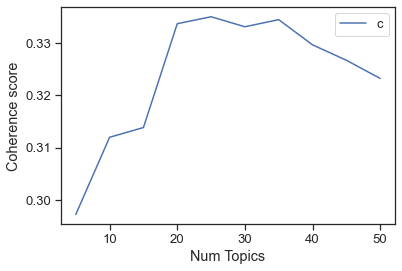

In [47]:
# Show graph
limit=55; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2972
Num Topics = 10  has Coherence Value of 0.312
Num Topics = 15  has Coherence Value of 0.3138
Num Topics = 20  has Coherence Value of 0.3336
Num Topics = 25  has Coherence Value of 0.335
Num Topics = 30  has Coherence Value of 0.3331
Num Topics = 35  has Coherence Value of 0.3344
Num Topics = 40  has Coherence Value of 0.3296
Num Topics = 45  has Coherence Value of 0.3267
Num Topics = 50  has Coherence Value of 0.3232


In [52]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(16,
  '0.029*"royalmailhelp" + 0.023*"royalmail" + 0.022*"parcel" + 0.017*"time" + '
  '0.017*"customer" + 0.017*"thank" + 0.017*"contact" + 0.017*"say" + '
  '0.016*"service" + 0.014*"day"'),
 (22,
  '0.039*"royalmail" + 0.035*"get" + 0.026*"delivery" + 0.019*"day" + '
  '0.019*"today" + 0.018*"parcel" + 0.015*"hermesparcel" + 0.015*"help" + '
  '0.014*"go" + 0.014*"service"'),
 (15,
  '0.022*"get" + 0.018*"send" + 0.016*"say" + 0.016*"think" + 0.015*"still" + '
  '0.015*"service" + 0.014*"hermesparcel" + 0.013*"delivery" + '
  '0.013*"parcelforce" + 0.012*"go"'),
 (4,
  '0.022*"thank" + 0.021*"parcel" + 0.021*"hermesparcel" + 0.019*"day" + '
  '0.015*"royalmail" + 0.014*"leave" + 0.014*"even" + 0.014*"door" + '
  '0.014*"driver" + 0.013*"get"'),
 (3,
  '0.050*"delivery" + 0.023*"parcel" + 0.021*"day" + 0.021*"deliver" + '
  '0.020*"hermesparcel" + 0.012*"royalmailhelp" + 0.012*"pay" + 0.012*"wait" + '
  '0.012*"try" + 0.012*"driver"'),
 (14,
  '0.034*"deliver" + 0.021*"parcel" + 0.

In [53]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

([(7, 0.8561536)], [(0, [7]), (1, [7]), (2, [7]), (3, [7]), (4, [7])], [(0, [(7, 0.99988735)]), (1, [(7, 0.9997054)]), (2, [(7, 0.99997944)]), (3, [(7, 0.99999255)]), (4, [(7, 0.99988735)])])


IndexError: list index out of range